In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 加载CIFAR-10数据集 训练集
from torchvision import datasets, transforms
data_path = '../data/cifar10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
                           ]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.4914, 0.4822, 0.4465),
                                       (0.2023, 0.1994, 0.2010))
                               ]))

# 将飞机和鸟摘出来，重新标注标签
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

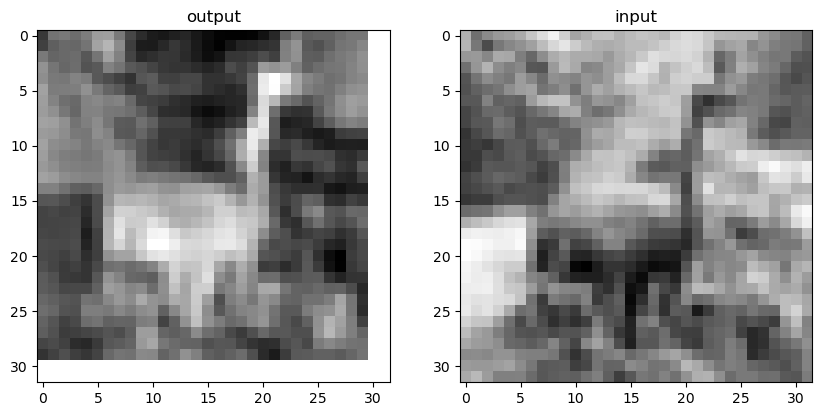

In [6]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(dim=0), cmap='gray')
plt.title('input')
# plt.savefig('testconv.png')
plt.show()

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

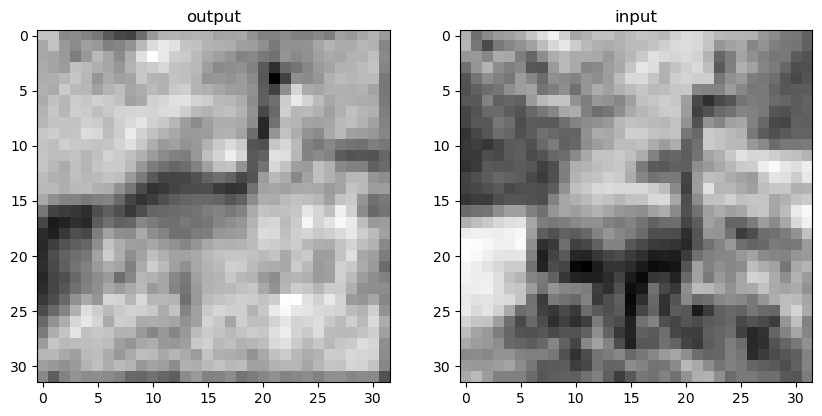

In [8]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(dim=0), cmap='gray')
plt.title('input')
# plt.savefig('testconv.png')
plt.show()

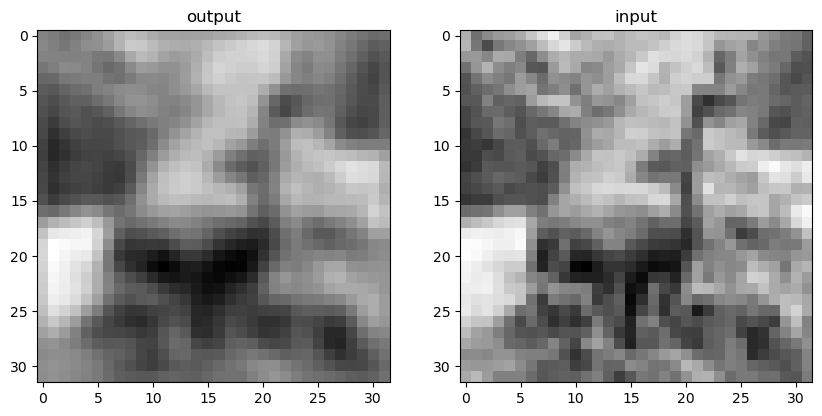

In [9]:
# 平滑效果
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(dim=0), cmap='gray')
plt.title('input')
plt.show()

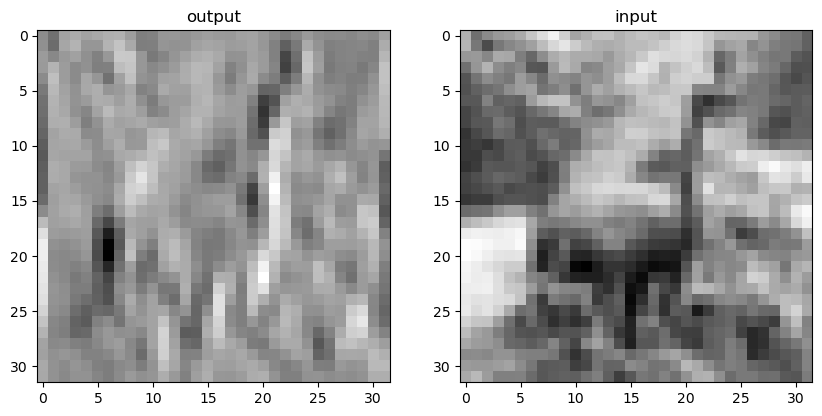

In [10]:
# 增强操作
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(dim=0), cmap='gray')
plt.title('input')
plt.show()

# 搭建卷积网络

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),

    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [12]:
# 改成类形式
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out


In [13]:
# 简化写法
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
# 计算运行时间损耗
import datetime

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [16]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [17]:
# 模型训练
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-03 00:18:24.851761 Epoch 1, Training loss 0.5640653605294076
2023-03-03 00:18:52.778491 Epoch 10, Training loss 0.3183240769964874
2023-03-03 00:19:22.762490 Epoch 20, Training loss 0.28572241117240516
2023-03-03 00:19:52.761023 Epoch 30, Training loss 0.26097364211158386
2023-03-03 00:20:22.760040 Epoch 40, Training loss 0.24175958311671664
2023-03-03 00:20:52.734393 Epoch 50, Training loss 0.22013957086642078
2023-03-03 00:21:22.747892 Epoch 60, Training loss 0.20476249657618772
2023-03-03 00:21:52.789404 Epoch 70, Training loss 0.18465949205835913
2023-03-03 00:22:22.824042 Epoch 80, Training loss 0.17048513469327786
2023-03-03 00:22:53.182440 Epoch 90, Training loss 0.1575021927428853
2023-03-03 00:23:23.550044 Epoch 100, Training loss 0.14416108854637025


In [18]:
# 计算准确率
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.88


In [19]:
# 保存模型
torch.save(model.state_dict(), data_path + 'birds_and_airplanes.pt')

In [20]:
# 加载模型
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_and_airplanes.pt'))

<All keys matched successfully>

In [21]:
validate(loaded_model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.88


# 使用GPU

In [22]:
# 使用GPU
import sys
device = (torch.device('mps') if sys.platform == 'darwin' else torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

print(f"Training on device {device}.")

Training on device mps.


In [23]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [25]:
model = Net().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-03 00:23:28.224325 Epoch 1, Training loss 0.5585001475492101
2023-03-03 00:23:32.265130 Epoch 10, Training loss 0.32680168377745683
2023-03-03 00:23:36.524683 Epoch 20, Training loss 0.292610883428033
2023-03-03 00:23:40.978957 Epoch 30, Training loss 0.26870679219437255
2023-03-03 00:23:45.235938 Epoch 40, Training loss 0.24626902747116272
2023-03-03 00:23:49.481173 Epoch 50, Training loss 0.23108079384086996
2023-03-03 00:23:53.738089 Epoch 60, Training loss 0.21151149664430102
2023-03-03 00:23:58.004893 Epoch 70, Training loss 0.1975702575057935
2023-03-03 00:24:02.256698 Epoch 80, Training loss 0.1841864862069962
2023-03-03 00:24:06.509458 Epoch 90, Training loss 0.1691459523644417
2023-03-03 00:24:10.752726 Epoch 100, Training loss 0.15810046069751119


In [26]:
# 增加模型宽度

class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [27]:
class NetWidth(nn.Module):
    def __init__(self, n_chansl=32):
        super().__init__()
        self.n_chansl = n_chansl
        self.conv1 = nn.Conv2d(3, n_chansl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chansl, n_chansl // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chansl // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

# Regularization 正则化

## L2 regularization

In [28]:
def traning_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            # L2 regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

## Dropout

In [29]:
# Dropout: A Simple Way to Prevent Neural Networks from Overfitting
# 训练时使用，测试时不使用
class NetDropout(nn.Module):
    def __init__(self, n_chansl=32):
        super().__init__()
        self.n_chansl = n_chansl
        self.conv1 = nn.Conv2d(3, n_chansl, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chansl, n_chansl // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chansl // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chansl // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# 模型训练
model = NetDropout().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-03 00:24:12.006030 Epoch 1, Training loss 0.5666260501002051
2023-03-03 00:24:17.418416 Epoch 10, Training loss 0.3672098285832982
2023-03-03 00:24:23.566506 Epoch 20, Training loss 0.33646676997849895
2023-03-03 00:24:29.698085 Epoch 30, Training loss 0.32116612478805956
2023-03-03 00:24:35.706941 Epoch 40, Training loss 0.29875356851110035
2023-03-03 00:24:41.766642 Epoch 50, Training loss 0.2914069231813121
2023-03-03 00:24:47.673729 Epoch 60, Training loss 0.2766949793525562
2023-03-03 00:24:53.555554 Epoch 70, Training loss 0.26635164677337475
2023-03-03 00:24:59.490876 Epoch 80, Training loss 0.2558769091109561
2023-03-03 00:25:05.606700 Epoch 90, Training loss 0.23882921191917103
2023-03-03 00:25:11.809637 Epoch 100, Training loss 0.23215786163594312


In [31]:
# 计算准确率
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


## Batch normalization

In [32]:
# Batch normalization: Accelerating deep network training by reducing internal covariate shift
class NetBatchNorm(nn.Module):
    def __init__(self, n_chansl=32):
        super().__init__()
        self.n_chansl = n_chansl
        self.conv1 = nn.Conv2d(3, n_chansl, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chansl)
        self.conv2 = nn.Conv2d(n_chansl, n_chansl // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chansl // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chansl // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chansl // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [33]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# 模型训练
model = NetBatchNorm().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-03 00:25:13.808493 Epoch 1, Training loss 0.4788404287426335
2023-03-03 00:25:19.471300 Epoch 10, Training loss 0.27554356520342976
2023-03-03 00:25:25.779977 Epoch 20, Training loss 0.21150759042827946
2023-03-03 00:25:31.983178 Epoch 30, Training loss 0.16805812374801393
2023-03-03 00:25:38.324597 Epoch 40, Training loss 0.13192789548426676
2023-03-03 00:25:44.634051 Epoch 50, Training loss 0.09998422989230248
2023-03-03 00:25:50.920328 Epoch 60, Training loss 0.07597123845747322
2023-03-03 00:25:57.233435 Epoch 70, Training loss 0.0601866922465859
2023-03-03 00:26:03.544368 Epoch 80, Training loss 0.04186704754532807
2023-03-03 00:26:09.859366 Epoch 90, Training loss 0.03917716931741519
2023-03-03 00:26:16.117495 Epoch 100, Training loss 0.02131080829425697


In [34]:
# 计算准确率
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.88


In [35]:
# 增加模型深度

In [36]:
class ResNetTest(nn.Module):
    def __init__(self, n_chansl=32):
        super().__init__()
        self.n_chansl = n_chansl
        self.conv1 = nn.Conv2d(3, n_chansl, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chansl, n_chansl // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chansl // 2, n_chansl // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chansl // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chansl // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [37]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# 模型训练
model = ResNetTest().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-03-03 00:34:18.897195 Epoch 1, Training loss 0.6196417356752286
2023-03-03 00:34:24.292768 Epoch 10, Training loss 0.3218596549170792
2023-03-03 00:34:30.271116 Epoch 20, Training loss 0.26840202965933807
2023-03-03 00:34:36.248999 Epoch 30, Training loss 0.2366225685758196
2023-03-03 00:34:42.239791 Epoch 40, Training loss 0.21008085915047653
2023-03-03 00:34:48.256811 Epoch 50, Training loss 0.17912905155473455
2023-03-03 00:34:54.312720 Epoch 60, Training loss 0.154185467892012
2023-03-03 00:35:00.335250 Epoch 70, Training loss 0.1258289491295055
2023-03-03 00:35:06.581614 Epoch 80, Training loss 0.10884436521275788
2023-03-03 00:35:12.785884 Epoch 90, Training loss 0.08024188942590336
2023-03-03 00:35:18.885045 Epoch 100, Training loss 0.061624374347412664


In [41]:
# 计算准确率
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device = device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.87
